In [1]:
import re
import random
import pickle

import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

/Users/tagir-kh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------------------------------------------
# 0. Настройки окружения
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [8]:
# --------------------------------------------------
# 1. Определяем целевые языки
#    В UN корпусе официальные языки: en, fr, es, ru, ar, zh.
#    Здесь выбираем: en, es, ru, ar, fr
# --------------------------------------------------
TARGET_LANGS = ["es", "ru", "ar", "fr"]  # целевые языки (без английского)
ALL_LANGS = ["en"] + TARGET_LANGS     # итоговая подборка 5 языков

MIN_WORDS = 5      # минимальное количество слов в каждом предложении
MAX_SAMPLES = 10000  # максимум примеров для формирования параллельного корпуса

def normalize_text(txt: str) -> str:
    """
    Убираем лишние пробелы и переносы для повышения точности сопоставления.
    """
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

In [12]:
# # -------------------------------------------------------------
# # 2. Сопоставление предложений по английскому тексту
# # -------------------------------------------------------------

import re
import random
from datasets import load_dataset

MIN_WORDS = 5      # минимальное количество слов
MAX_LEN = 400      # максимальное количество слов
MAX_SAMPLES = 100000  # берём первые 100k примеров в каждом датасете

def normalize_text(txt: str) -> str:
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

# Целевые языки и соответствующие конфигурации:
# Для en-es, en-fr, en-ru — английский всегда в ключе "en".
# Для арабского используем config "ar-en" — здесь оба перевода находятся в "translation".
lang_configs = {
    "es": "en-es",
    "fr": "en-fr",
    "ru": "en-ru",
    "ar": "ar-en"
}

# Словарь для хранения пар: для каждого языка будет словарь {en_text: foreign_text}
parallel_data = {}

for lang, config in lang_configs.items():
    print(f"Loading dataset for config: {config}")
    ds = load_dataset("Helsinki-NLP/multiun", config, split=f"train[:{MAX_SAMPLES}]")
    print(ds)
    data_dict = {}
    for example in ds:
        # Получаем словарь переводов из поля "translation"
        trans = example["translation"]

        # Для конфигураций en-es, en-fr, en-ru
        if config in ["en-es", "en-fr", "en-ru"]:
            if "en" in trans and lang in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans[lang])
            else:
                continue
        # Для конфигурации ar-en (арабский – английский)
        elif config == "ar-en":
            if "ar" in trans and "en" in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans["ar"])
            else:
                continue
        else:
            continue

        if en_text and foreign_text:
            if (len(en_text.split()) >= MIN_WORDS and len(foreign_text.split()) >= MIN_WORDS and
                len(en_text.split()) <= MAX_LEN and len(foreign_text.split()) <= MAX_LEN):
                data_dict[en_text] = foreign_text
    parallel_data[lang] = data_dict
    print(f"Collected {len(data_dict)} valid pairs for config {config}")

Loading dataset for config: en-es
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 86392 valid pairs for config en-es
Loading dataset for config: en-fr


Generating train split: 100%|█| 13172019/13172019 [00:05<00:00, 2321737.67 examp


Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 83338 valid pairs for config en-fr
Loading dataset for config: en-ru


Generating train split: 100%|█| 11654416/11654416 [00:06<00:00, 1818130.15 examp


Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 84128 valid pairs for config en-ru
Loading dataset for config: ar-en


Generating train split: 100%|█| 9759125/9759125 [00:04<00:00, 1955110.41 example


Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 85140 valid pairs for config ar-en


In [13]:
# --------------------------------------------------
# 3. Находим пересечение английских предложений, 
#    которые есть во ВСЕХ целевых языках
# --------------------------------------------------
# Находим пересечение английских предложений среди всех наборов
common_en_texts = None
for lang in lang_configs.keys():
    keys_set = set(parallel_data[lang].keys())
    if common_en_texts is None:
        common_en_texts = keys_set
    else:
        common_en_texts = common_en_texts.intersection(keys_set)
common_en_texts = list(common_en_texts)
print("Found total common English texts:", len(common_en_texts))

# Формируем итоговый корпус с 5 языками (en + es, fr, ru, ar)
five_lang_data = []
for en_text in common_en_texts:
    entry = {"en": en_text}
    valid = True
    for lang in lang_configs.keys():
        if en_text in parallel_data[lang]:
            entry[lang] = parallel_data[lang][en_text]
        else:
            valid = False
            break
    if valid:
        five_lang_data.append(entry)
print("Final 5-lang parallel samples:", len(five_lang_data))

Found total common English texts: 53964
Final 5-lang parallel samples: 53964


In [31]:
# --------------------------------------------------
# 4. Формируем итоговый список (5 языков: en + 4 target)
# --------------------------------------------------
N = 10_000
if len(common_en_texts) > N:
    common_en_texts = random.sample(common_en_texts, N)

five_lang_data = []
for en_txt in common_en_texts:
    entry = {
        "en": en_txt,
        "es": parallel_data["es"][en_txt],
        "ru": parallel_data["ru"][en_txt],
        "ar": parallel_data["ar"][en_txt],
        "fr": parallel_data["fr"][en_txt],
    }
    five_lang_data.append(entry)

print("Final 5-lang parallel samples:", len(five_lang_data))

Final 5-lang parallel samples: 10000


In [32]:
# --------------------------------------------------
# 5. Фильтрация слишком коротких и дубликатов
# --------------------------------------------------
def count_words(sentence: str) -> int:
    return len(sentence.strip().split())

def is_too_short(item, min_words=3) -> bool:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        if not item[lang] or count_words(item[lang]) < min_words:
            return True
    return False

def filter_short_and_duplicates(data_list, min_words=3):
    seen = set()
    cleaned_data = []
    for item in data_list:
        if is_too_short(item, min_words=min_words):
            continue
        key = (item["en"], item["es"], item["ru"], item["ar"], item["fr"])
        if key not in seen:
            seen.add(key)
            cleaned_data.append(item)
    return cleaned_data

clean_data = filter_short_and_duplicates(five_lang_data, min_words=5)
print("After filtering short/duplicates:", len(clean_data))

After filtering short/duplicates: 10000


In [39]:
# --------------------------------------------------
# 6. Инициализируем модель для извлечения эмбеддингов
# --------------------------------------------------

MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

def get_sentence_embedding(sentence: str) -> np.ndarray:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Получаем эмбеддинги токенов из последнего слоя
        token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_dim)
        # Используем attention_mask для учета ненулевых токенов
        attention_mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
        sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
    return embeddings[0].cpu().numpy()

In [40]:
# --------------------------------------------------
# 7. Извлекаем эмбеддинги для всех (en, es, ru, ar, de)
# --------------------------------------------------
all_sentences = []
all_labels = []
for item in clean_data:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        all_sentences.append(item[lang])
        all_labels.append(lang)

print("Total sentences for embeddings:", len(all_sentences))

embeddings = []
for i, sent in enumerate(all_sentences):
    emb = get_sentence_embedding(sent)
    embeddings.append(emb)
    if (i+1) % 500 == 0:
        print(f"Embedded {i+1} sentences...")

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)

Total sentences for embeddings: 50000
Embedded 500 sentences...
Embedded 1000 sentences...
Embedded 1500 sentences...
Embedded 2000 sentences...
Embedded 2500 sentences...
Embedded 3000 sentences...
Embedded 3500 sentences...
Embedded 4000 sentences...
Embedded 4500 sentences...
Embedded 5000 sentences...
Embedded 5500 sentences...
Embedded 6000 sentences...
Embedded 6500 sentences...
Embedded 7000 sentences...
Embedded 7500 sentences...
Embedded 8000 sentences...
Embedded 8500 sentences...
Embedded 9000 sentences...
Embedded 9500 sentences...
Embedded 10000 sentences...
Embedded 10500 sentences...
Embedded 11000 sentences...
Embedded 11500 sentences...
Embedded 12000 sentences...
Embedded 12500 sentences...
Embedded 13000 sentences...
Embedded 13500 sentences...
Embedded 14000 sentences...
Embedded 14500 sentences...
Embedded 15000 sentences...
Embedded 15500 sentences...
Embedded 16000 sentences...
Embedded 16500 sentences...
Embedded 17000 sentences...
Embedded 17500 sentences...
Em

In [41]:
# --------------------------------------------------
# 8. Сохраняем результаты в pickle 
# --------------------------------------------------
data_to_save = {
    'sentences': all_sentences,
    'labels': all_labels,
    'embeddings': embeddings
}
with open('exp1_data_embeddings.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)
print("All data saved to 'exp1_data_embeddings.pkl'")

All data saved to 'exp1_data_embeddings.pkl'


In [42]:
# --------------------------------------------------
# 9. t-SNE визуализация
# --------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

def plot_tsne_with_different_perplexities(embeddings, labels, perplexities=[2, 5, 15, 30, 50, 100], n_samples=500):
    """
    Строит несколько t-SNE-графиков с разными perplexity.
    embeddings: np.ndarray (N, dim)
    labels: список или массив меток (длина N)
    perplexities: список значений perplexity для t-SNE
    n_samples: сколько случайных примеров берём для ускорения
    """
    # Подвыборка данных
    if len(labels) > n_samples:
        idx = random.sample(range(len(labels)), n_samples)
    else:
        idx = range(len(labels))

    sub_emb = embeddings[idx, :]
    sub_labels = [labels[i] for i in idx]
    
    # Уникальные языки (или метки), чтобы задавать цвета
    unique_langs = sorted(list(set(sub_labels)))
    color_map = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}
    
    n_plots = len(perplexities)
    plt.figure(figsize=(16, 4 * n_plots)) 

    for i, perp in enumerate(perplexities, 1):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        coords = tsne.fit_transform(sub_emb)

        plt.subplot(n_plots, 1, i)
        for lang in unique_langs:
            # Выбираем точки для конкретного языка
            xy = coords[[j for j, l in enumerate(sub_labels) if l == lang]]
            plt.scatter(xy[:, 0], xy[:, 1], 
                        c=color_map.get(lang, "gray"), 
                        label=lang, alpha=0.5)
        plt.title(f"t-SNE (perplexity={perp})")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

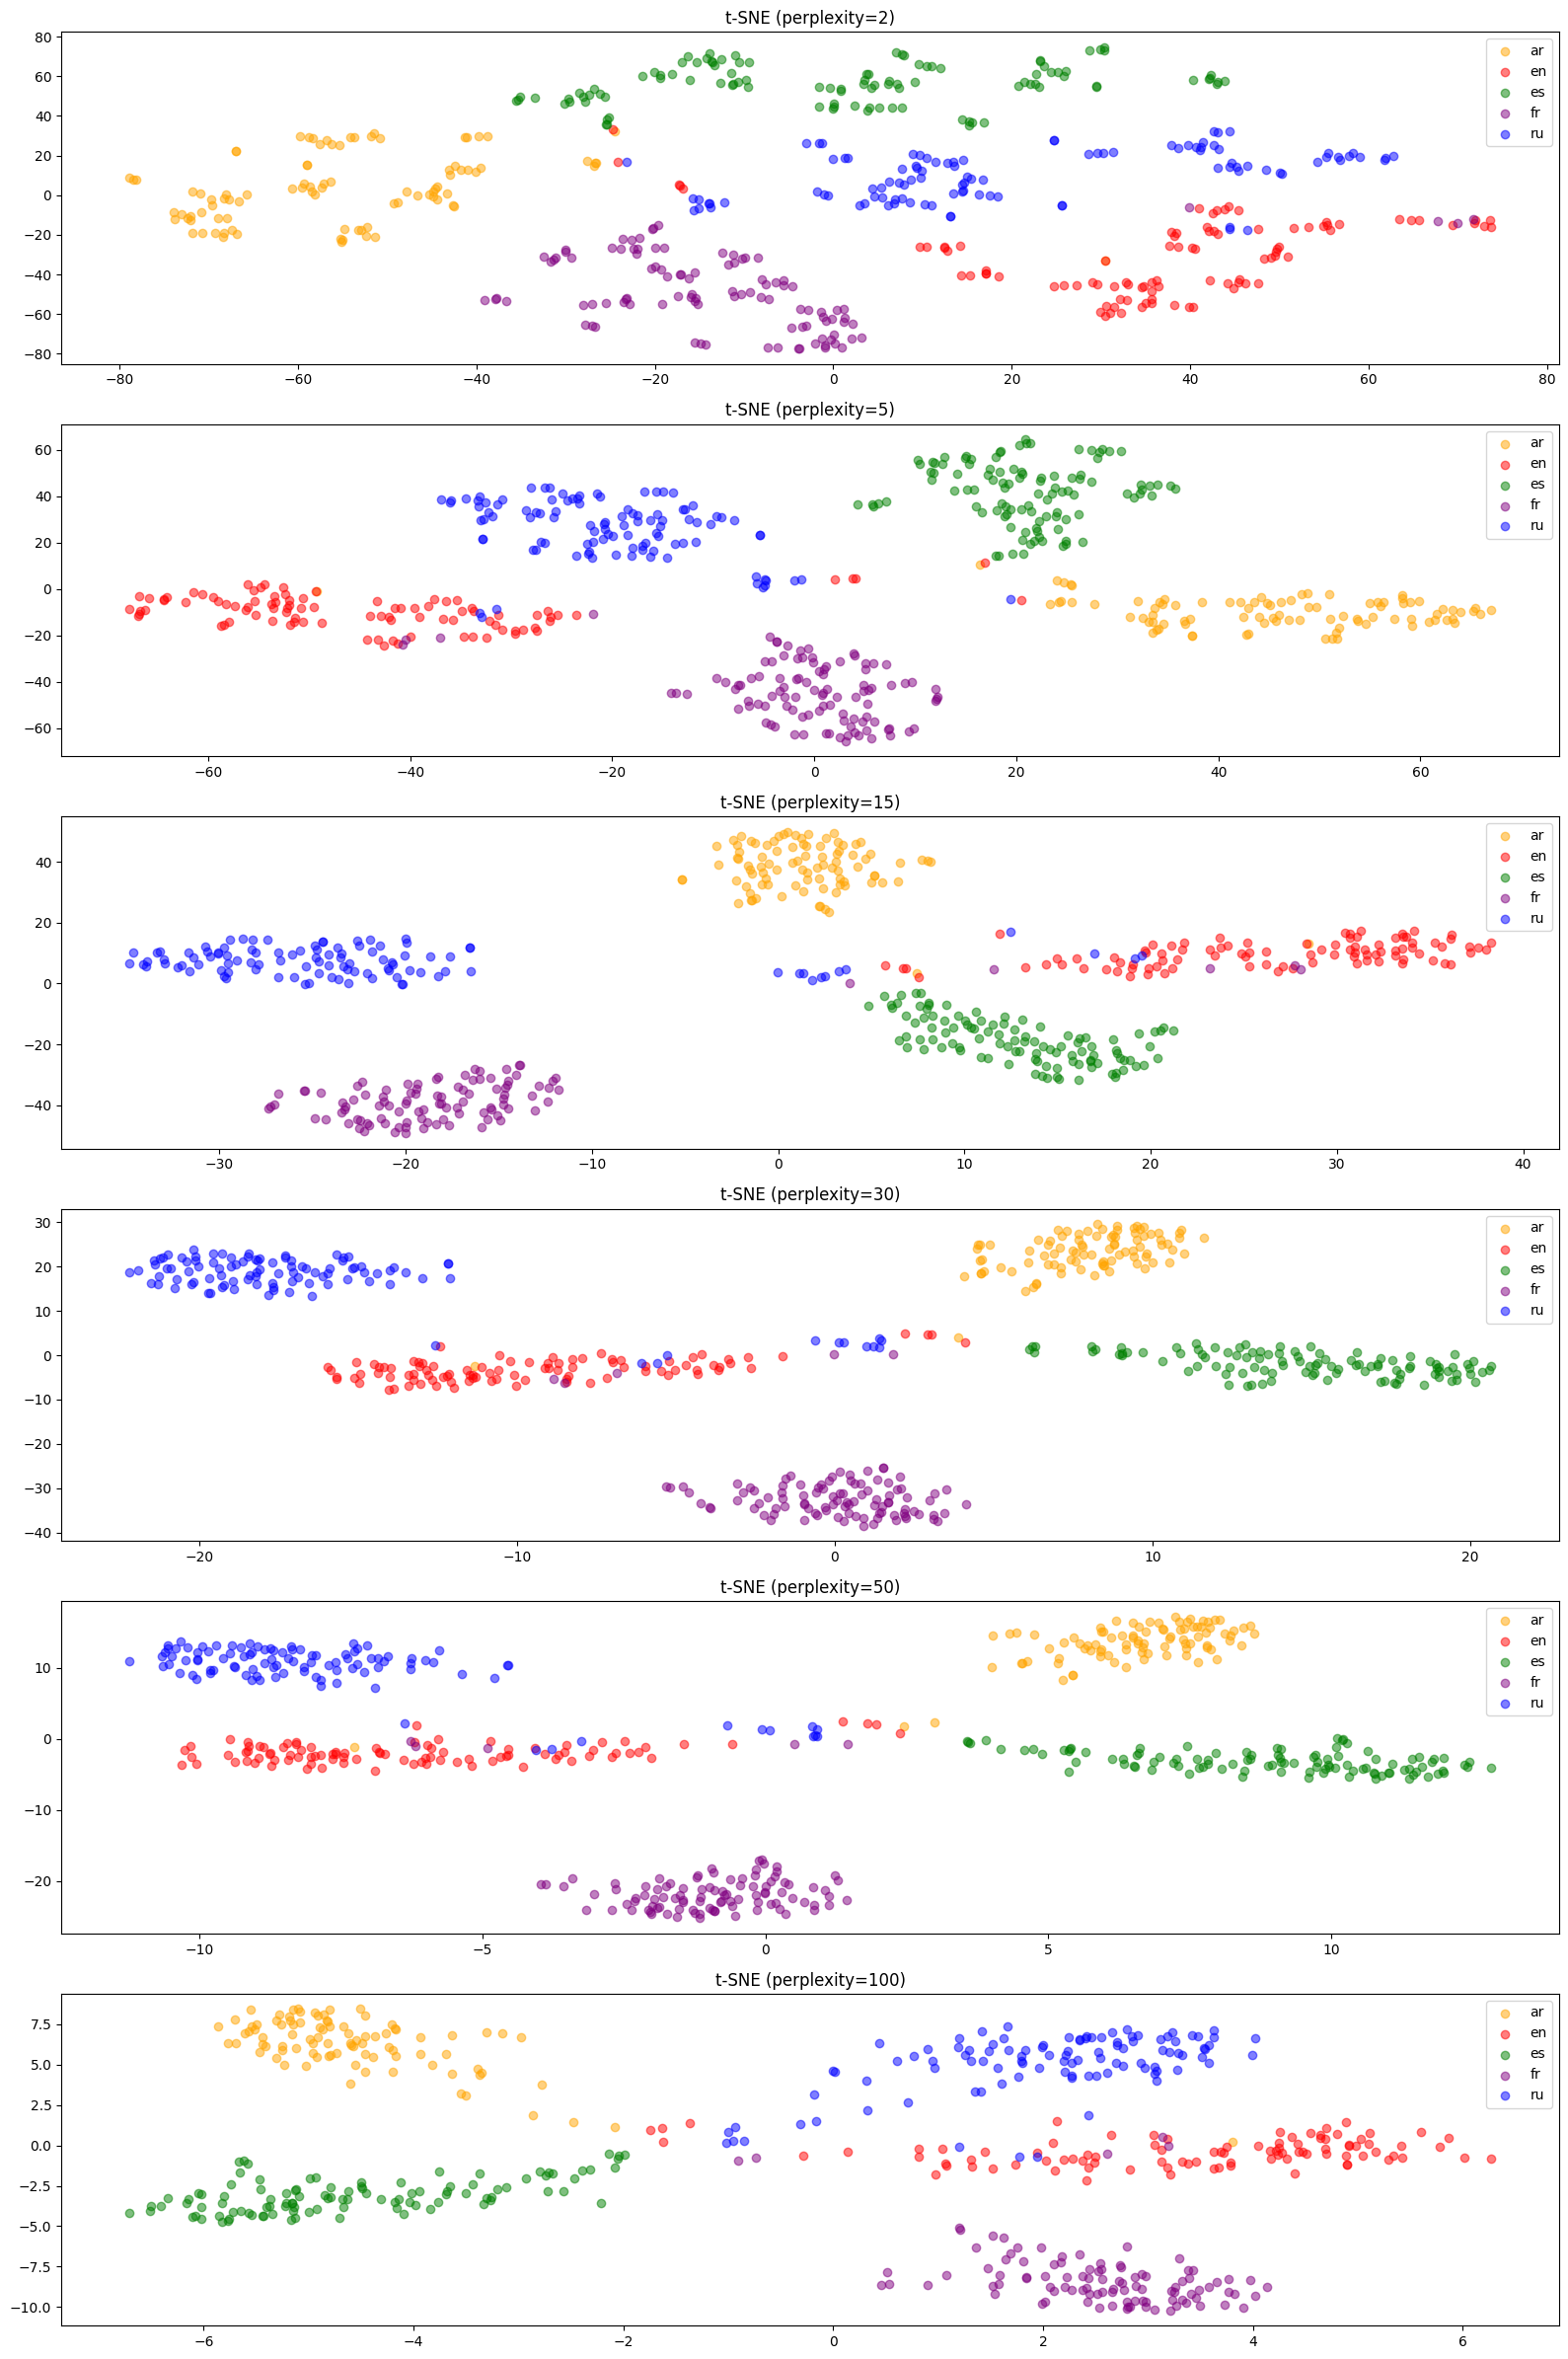

In [43]:
plot_tsne_with_different_perplexities(embeddings, all_labels, [2, 5, 15, 30, 50, 100], n_samples=500)

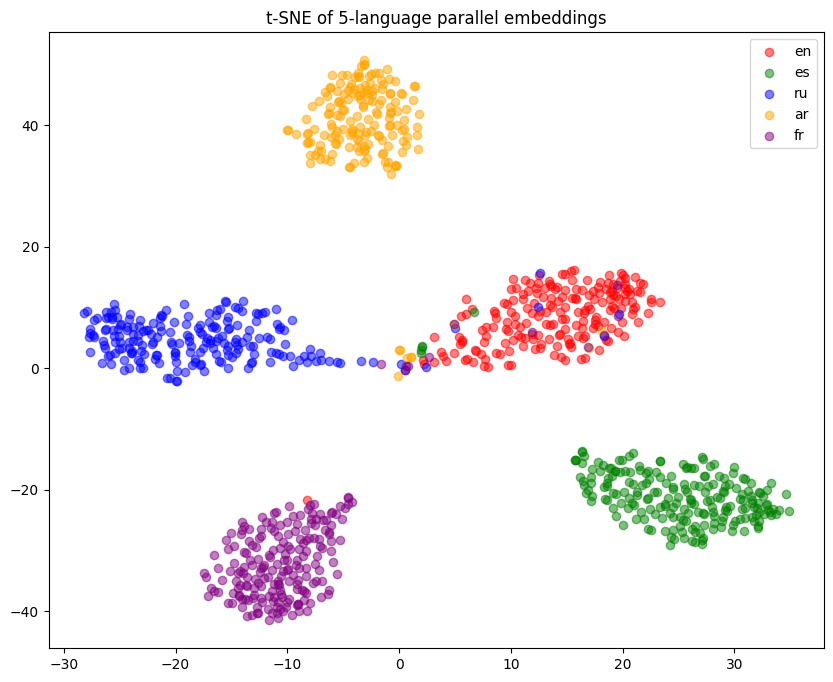

In [44]:
N_TSNE = 1000
if len(all_sentences) > N_TSNE:
    idx = random.sample(range(len(all_sentences)), N_TSNE)
else:
    idx = range(len(all_sentences))

selected_emb = embeddings[idx, :]
selected_labels = [all_labels[i] for i in idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(selected_emb)

colors = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}

plt.figure(figsize=(10, 8))
for lang in colors.keys():
    xy = tsne_coords[[i for i, l in enumerate(selected_labels) if l == lang]]
    plt.scatter(xy[:, 0], xy[:, 1], c=colors[lang], label=lang, alpha=0.5)

plt.legend()
plt.title("t-SNE of 5-language parallel embeddings")
plt.show()

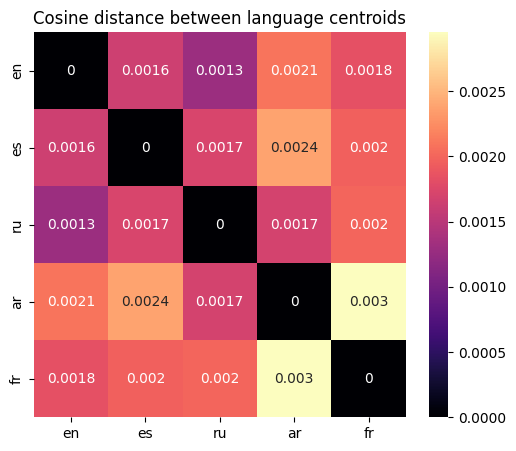

In [46]:
# --------------------------------------------------
# 10. Косинусные расстояния между центроидами языков
# --------------------------------------------------
langs = ["en", "es", "ru", "ar", "fr"]
lang2vecs = {lang: [] for lang in langs}

for emb, label in zip(embeddings, all_labels):
    lang2vecs[label].append(emb)

# Считаем центроиды
lang_centroids = {}
for lang in langs:
    arr = np.vstack(lang2vecs[lang])
    lang_centroids[lang] = arr.mean(axis=0, keepdims=True)

centroids_matrix = np.vstack([lang_centroids[l] for l in langs])
dist_matrix = cosine_distances(centroids_matrix, centroids_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(dist_matrix, xticklabels=langs, yticklabels=langs,
            annot=True, cmap="magma")
plt.title("Cosine distance between language centroids")
plt.show()

---

In [ ]:
# model Qwen/Qwen2.5-1.5B

In [1]:
import re
import random
import pickle

import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

/Users/tagir-kh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --------------------------------------------------
# 0. Настройки окружения
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# --------------------------------------------------
# 1. Определяем целевые языки
#    В UN корпусе официальные языки: en, fr, es, ru, ar, zh.
#    Здесь выбираем: en, es, ru, ar, fr
# --------------------------------------------------
TARGET_LANGS = ["es", "ru", "ar", "fr"]  # целевые языки (без английского)
ALL_LANGS = ["en"] + TARGET_LANGS     # итоговая подборка 5 языков

MIN_WORDS = 5      # минимальное количество слов в каждом предложении
MAX_SAMPLES = 10000  # максимум примеров для формирования параллельного корпуса

def normalize_text(txt: str) -> str:
    """
    Убираем лишние пробелы и переносы для повышения точности сопоставления.
    """
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

In [4]:
# # -------------------------------------------------------------
# # 2. Сопоставление предложений по английскому тексту
# # -------------------------------------------------------------

import re
import random
from datasets import load_dataset

MIN_WORDS = 5      # минимальное количество слов
MAX_LEN = 400      # максимальное количество слов
MAX_SAMPLES = 100000  # берём первые 100k примеров в каждом датасете

def normalize_text(txt: str) -> str:
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

# Целевые языки и соответствующие конфигурации:
# Для en-es, en-fr, en-ru — английский всегда в ключе "en".
# Для арабского используем config "ar-en" — здесь оба перевода находятся в "translation".
lang_configs = {
    "es": "en-es",
    "fr": "en-fr",
    "ru": "en-ru",
    "ar": "ar-en"
}

# Словарь для хранения пар: для каждого языка будет словарь {en_text: foreign_text}
parallel_data = {}

for lang, config in lang_configs.items():
    print(f"Loading dataset for config: {config}")
    ds = load_dataset("Helsinki-NLP/multiun", config, split=f"train[:{MAX_SAMPLES}]")
    print(ds)
    data_dict = {}
    for example in ds:
        # Получаем словарь переводов из поля "translation"
        trans = example["translation"]

        # Для конфигураций en-es, en-fr, en-ru
        if config in ["en-es", "en-fr", "en-ru"]:
            if "en" in trans and lang in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans[lang])
            else:
                continue
        # Для конфигурации ar-en (арабский – английский)
        elif config == "ar-en":
            if "ar" in trans and "en" in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans["ar"])
            else:
                continue
        else:
            continue

        if en_text and foreign_text:
            if (len(en_text.split()) >= MIN_WORDS and len(foreign_text.split()) >= MIN_WORDS and
                len(en_text.split()) <= MAX_LEN and len(foreign_text.split()) <= MAX_LEN):
                data_dict[en_text] = foreign_text
    parallel_data[lang] = data_dict
    print(f"Collected {len(data_dict)} valid pairs for config {config}")

Loading dataset for config: en-es
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 86392 valid pairs for config en-es
Loading dataset for config: en-fr
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 83338 valid pairs for config en-fr
Loading dataset for config: en-ru
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 84128 valid pairs for config en-ru
Loading dataset for config: ar-en
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 85140 valid pairs for config ar-en


In [5]:
# --------------------------------------------------
# 3. Находим пересечение английских предложений, 
#    которые есть во ВСЕХ целевых языках
# --------------------------------------------------
# Находим пересечение английских предложений среди всех наборов
common_en_texts = None
for lang in lang_configs.keys():
    keys_set = set(parallel_data[lang].keys())
    if common_en_texts is None:
        common_en_texts = keys_set
    else:
        common_en_texts = common_en_texts.intersection(keys_set)
common_en_texts = list(common_en_texts)
print("Found total common English texts:", len(common_en_texts))

# Формируем итоговый корпус с 5 языками (en + es, fr, ru, ar)
five_lang_data = []
for en_text in common_en_texts:
    entry = {"en": en_text}
    valid = True
    for lang in lang_configs.keys():
        if en_text in parallel_data[lang]:
            entry[lang] = parallel_data[lang][en_text]
        else:
            valid = False
            break
    if valid:
        five_lang_data.append(entry)
print("Final 5-lang parallel samples:", len(five_lang_data))

Found total common English texts: 53964
Final 5-lang parallel samples: 53964


In [6]:
# --------------------------------------------------
# 4. Формируем итоговый список (5 языков: en + 4 target)
# --------------------------------------------------
N = 10_000
if len(common_en_texts) > N:
    common_en_texts = random.sample(common_en_texts, N)

five_lang_data = []
for en_txt in common_en_texts:
    entry = {
        "en": en_txt,
        "es": parallel_data["es"][en_txt],
        "ru": parallel_data["ru"][en_txt],
        "ar": parallel_data["ar"][en_txt],
        "fr": parallel_data["fr"][en_txt],
    }
    five_lang_data.append(entry)

print("Final 5-lang parallel samples:", len(five_lang_data))

Final 5-lang parallel samples: 10000


In [7]:
# --------------------------------------------------
# 5. Фильтрация слишком коротких и дубликатов
# --------------------------------------------------
def count_words(sentence: str) -> int:
    return len(sentence.strip().split())

def is_too_short(item, min_words=3) -> bool:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        if not item[lang] or count_words(item[lang]) < min_words:
            return True
    return False

def filter_short_and_duplicates(data_list, min_words=3):
    seen = set()
    cleaned_data = []
    for item in data_list:
        if is_too_short(item, min_words=min_words):
            continue
        key = (item["en"], item["es"], item["ru"], item["ar"], item["fr"])
        if key not in seen:
            seen.add(key)
            cleaned_data.append(item)
    return cleaned_data

clean_data = filter_short_and_duplicates(five_lang_data, min_words=5)
print("After filtering short/duplicates:", len(clean_data))

After filtering short/duplicates: 10000


In [38]:
# --------------------------------------------------
# 6. Инициализируем модель для извлечения эмбеддингов
# --------------------------------------------------

MODEL_NAME = "Qwen/Qwen2.5-1.5B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

def get_sentence_embedding(sentence: str) -> np.ndarray:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Получаем эмбеддинги токенов из последнего слоя
        token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_dim)
        # Используем attention_mask для учета ненулевых токенов
        attention_mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
        sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
    return embeddings[0].cpu().numpy()

In [39]:
# --------------------------------------------------
# 7. Извлекаем эмбеддинги для всех (en, es, ru, ar, de)
# --------------------------------------------------
all_sentences = []
all_labels = []
for item in clean_data:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        all_sentences.append(item[lang])
        all_labels.append(lang)

print("Total sentences for embeddings:", len(all_sentences))

embeddings = []
for i, sent in enumerate(all_sentences):
    emb = get_sentence_embedding(sent)
    embeddings.append(emb)
    if (i+1) % 500 == 0:
        print(f"Embedded {i+1} sentences...")

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)

Total sentences for embeddings: 50000
Embedded 500 sentences...
Embedded 1000 sentences...
Embedded 1500 sentences...
Embedded 2000 sentences...
Embedded 2500 sentences...
Embedded 3000 sentences...
Embedded 3500 sentences...
Embedded 4000 sentences...
Embedded 4500 sentences...
Embedded 5000 sentences...
Embedded 5500 sentences...
Embedded 6000 sentences...
Embedded 6500 sentences...
Embedded 7000 sentences...
Embedded 7500 sentences...
Embedded 8000 sentences...
Embedded 8500 sentences...
Embedded 9000 sentences...
Embedded 9500 sentences...
Embedded 10000 sentences...
Embedded 10500 sentences...
Embedded 11000 sentences...
Embedded 11500 sentences...
Embedded 12000 sentences...
Embedded 12500 sentences...
Embedded 13000 sentences...
Embedded 13500 sentences...
Embedded 14000 sentences...
Embedded 14500 sentences...
Embedded 15000 sentences...
Embedded 15500 sentences...
Embedded 16000 sentences...
Embedded 16500 sentences...
Embedded 17000 sentences...
Embedded 17500 sentences...
Em

In [40]:
# --------------------------------------------------
# 8. Сохраняем результаты в pickle 
# --------------------------------------------------
data_to_save = {
    'sentences': all_sentences,
    'labels': all_labels,
    'embeddings': embeddings
}
with open('exp1_data_embeddings_qwen.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)
print("All data saved to 'exp1_data_embeddings_qwen.pkl'")

All data saved to 'exp1_data_embeddings_qwen.pkl'


In [41]:
# --------------------------------------------------
# 9. t-SNE визуализация
# --------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

def plot_tsne_with_different_perplexities(embeddings, labels, perplexities=[2, 5, 15, 30, 50, 100], n_samples=500):
    """
    Строит несколько t-SNE-графиков с разными perplexity.
    embeddings: np.ndarray (N, dim)
    labels: список или массив меток (длина N)
    perplexities: список значений perplexity для t-SNE
    n_samples: сколько случайных примеров берём для ускорения
    """
    # Подвыборка данных
    if len(labels) > n_samples:
        idx = random.sample(range(len(labels)), n_samples)
    else:
        idx = range(len(labels))

    sub_emb = embeddings[idx, :]
    sub_labels = [labels[i] for i in idx]
    
    # Уникальные языки (или метки), чтобы задавать цвета
    unique_langs = sorted(list(set(sub_labels)))
    color_map = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}
    
    n_plots = len(perplexities)
    plt.figure(figsize=(16, 4 * n_plots)) 

    for i, perp in enumerate(perplexities, 1):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        coords = tsne.fit_transform(sub_emb)

        plt.subplot(n_plots, 1, i)
        for lang in unique_langs:
            # Выбираем точки для конкретного языка
            xy = coords[[j for j, l in enumerate(sub_labels) if l == lang]]
            plt.scatter(xy[:, 0], xy[:, 1], 
                        c=color_map.get(lang, "gray"), 
                        label=lang, alpha=0.5)
        plt.title(f"t-SNE (perplexity={perp})")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [45]:
embeddings.shape[0]

50000

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


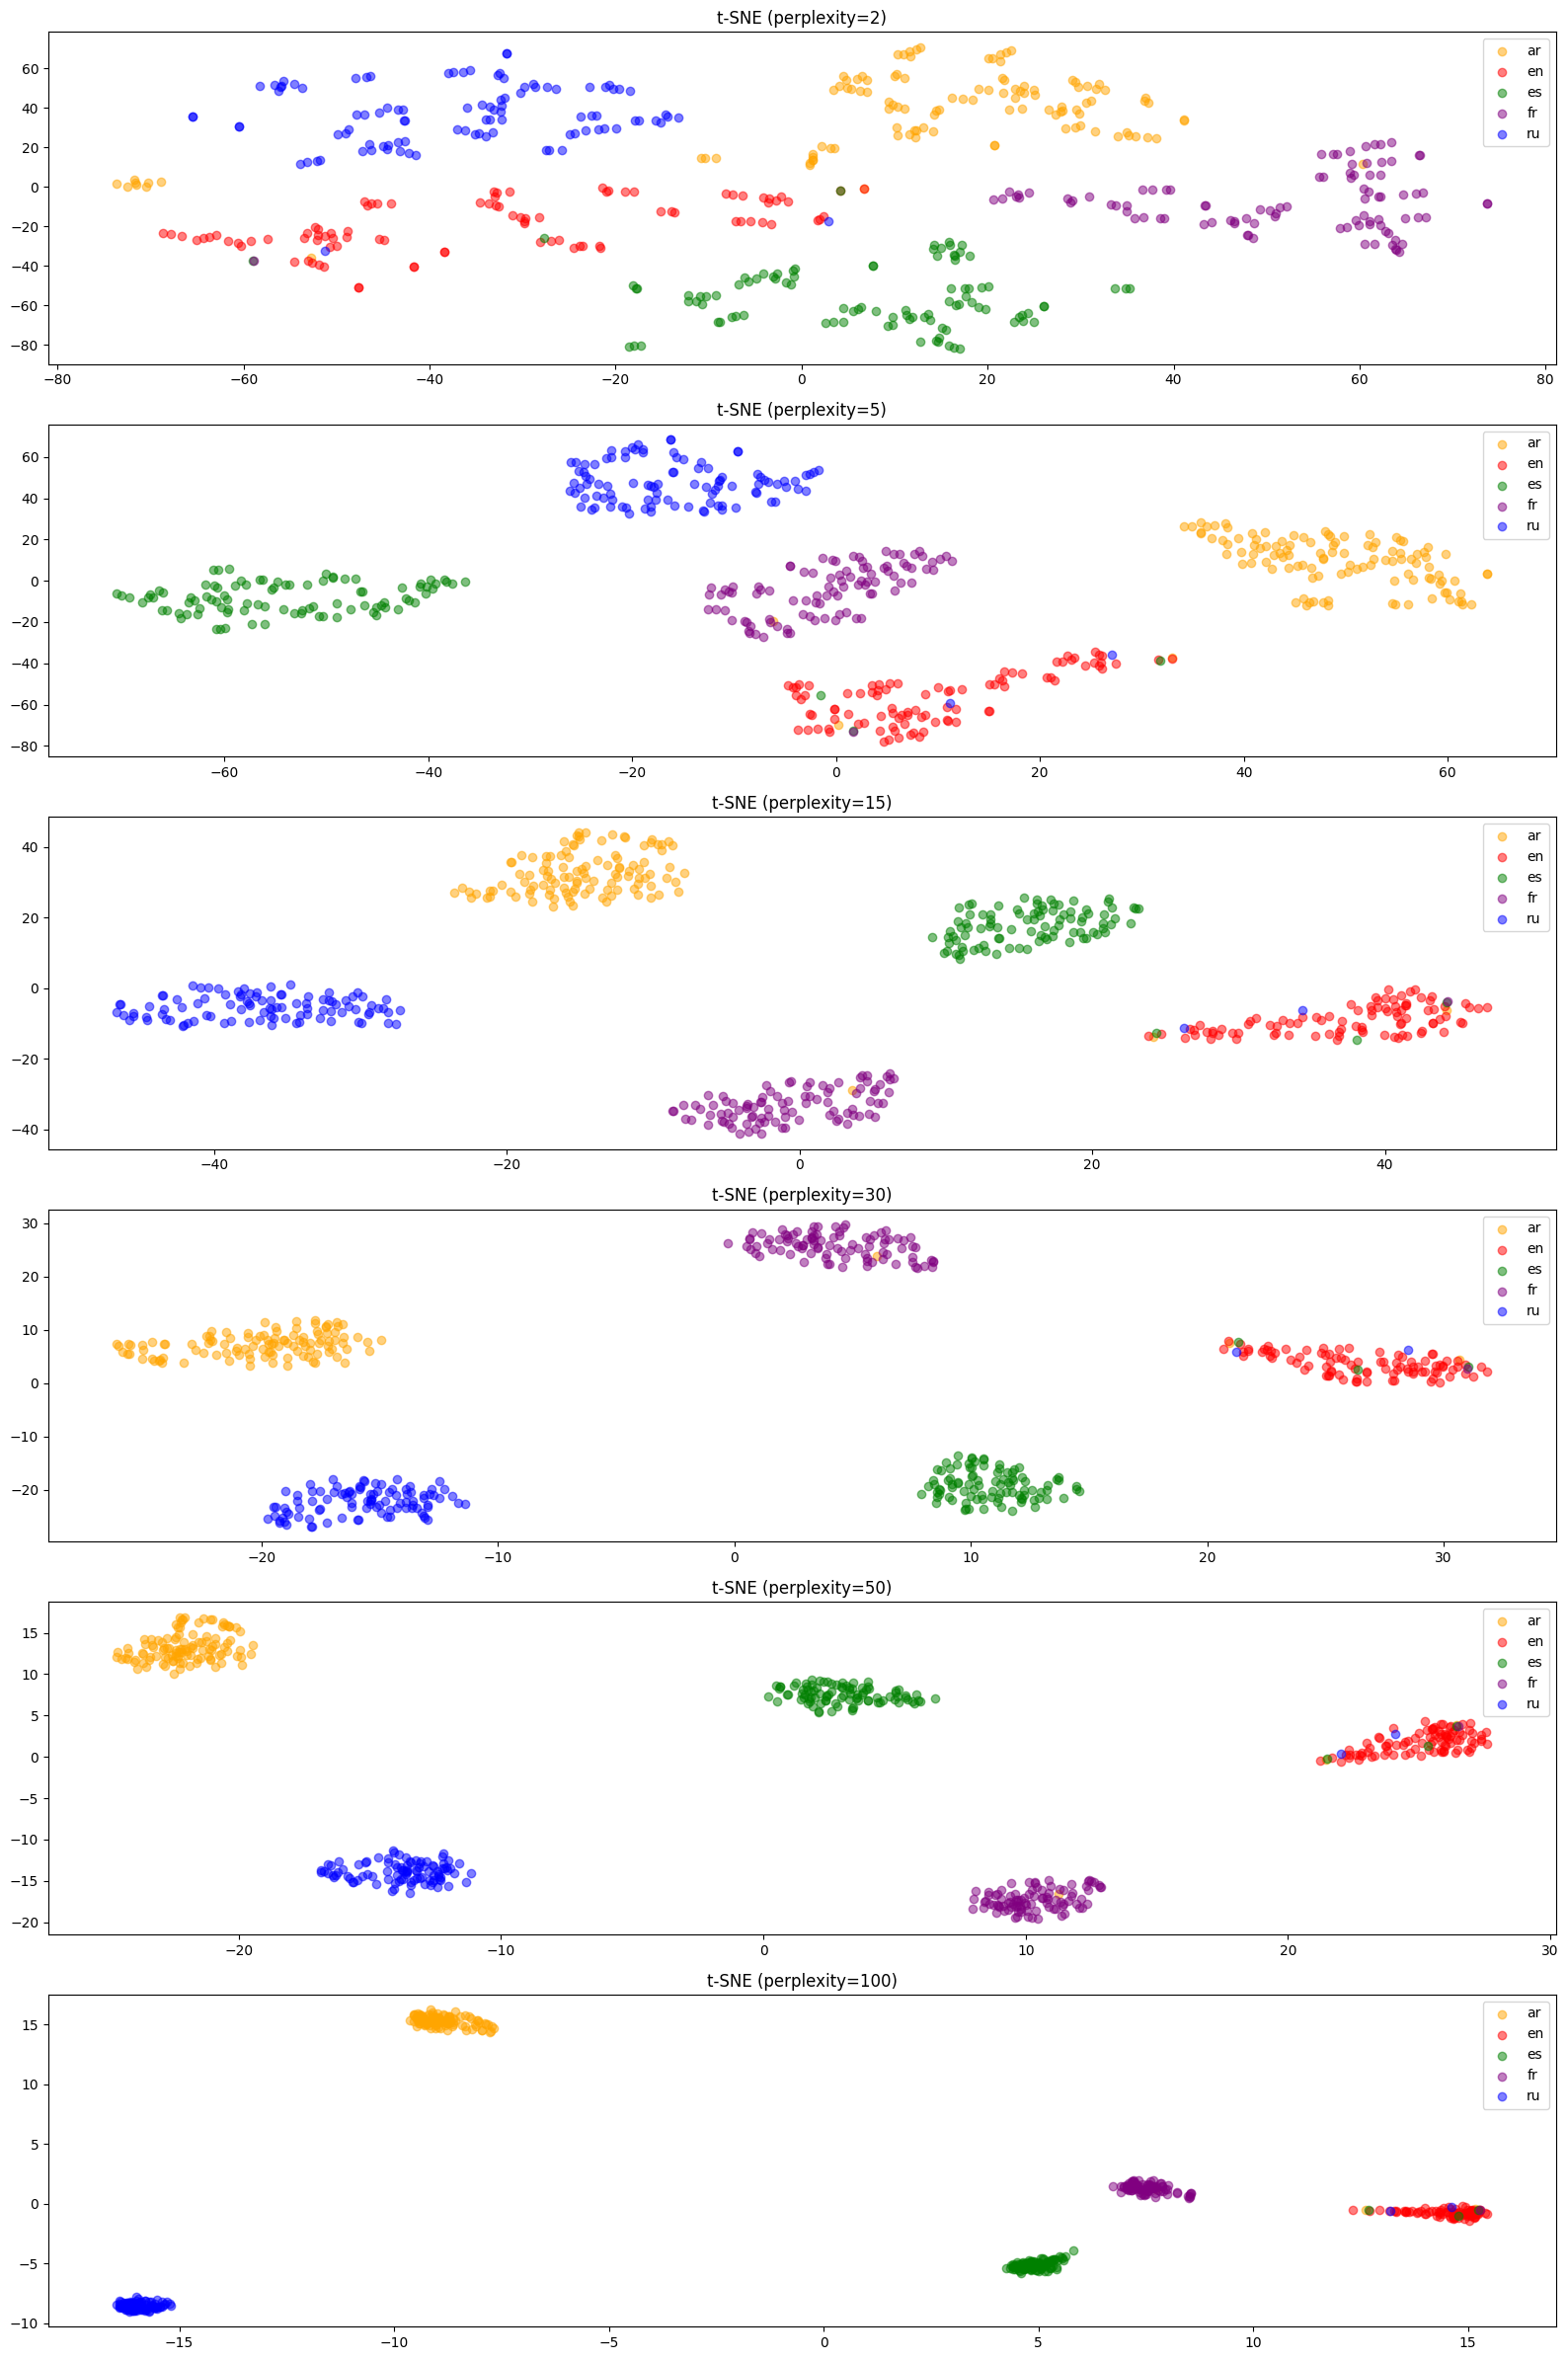

In [42]:
plot_tsne_with_different_perplexities(embeddings, all_labels, [2, 5, 15, 30, 50, 100], n_samples=500)

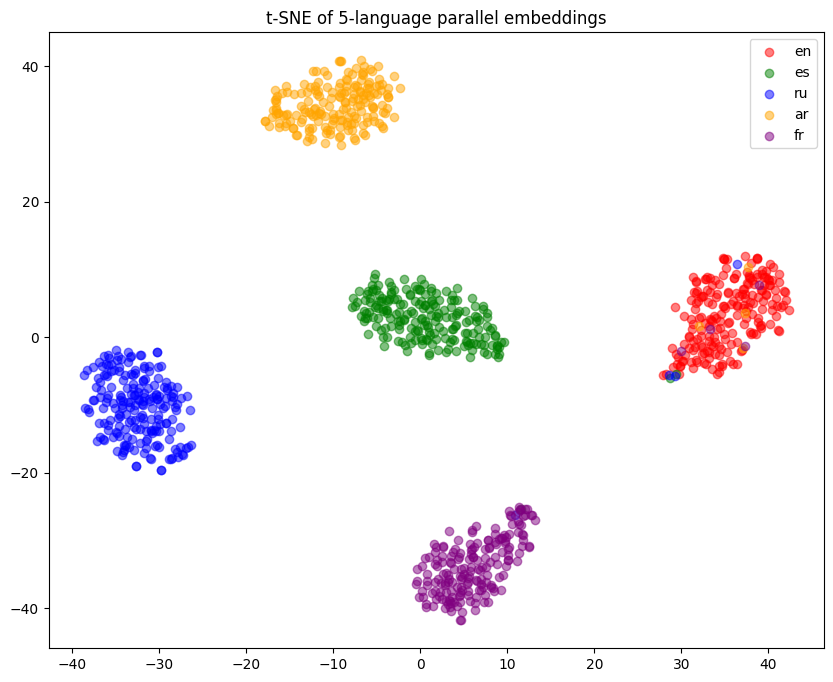

In [43]:
N_TSNE = 1000
if len(all_sentences) > N_TSNE:
    idx = random.sample(range(len(all_sentences)), N_TSNE)
else:
    idx = range(len(all_sentences))

selected_emb = embeddings[idx, :]
selected_labels = [all_labels[i] for i in idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(selected_emb)

colors = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}

plt.figure(figsize=(10, 8))
for lang in colors.keys():
    xy = tsne_coords[[i for i, l in enumerate(selected_labels) if l == lang]]
    plt.scatter(xy[:, 0], xy[:, 1], c=colors[lang], label=lang, alpha=0.5)

plt.legend()
plt.title("t-SNE of 5-language parallel embeddings")
plt.show()

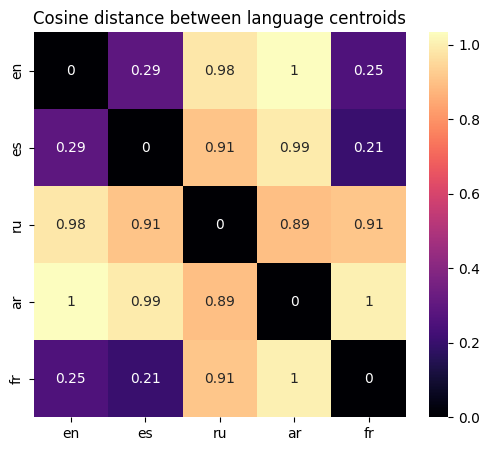

In [44]:
# --------------------------------------------------
# 10. Косинусные расстояния между центроидами языков
# --------------------------------------------------
langs = ["en", "es", "ru", "ar", "fr"]
lang2vecs = {lang: [] for lang in langs}

for emb, label in zip(embeddings, all_labels):
    lang2vecs[label].append(emb)

# Считаем центроиды
lang_centroids = {}
for lang in langs:
    arr = np.vstack(lang2vecs[lang])
    lang_centroids[lang] = arr.mean(axis=0, keepdims=True)

centroids_matrix = np.vstack([lang_centroids[l] for l in langs])
dist_matrix = cosine_distances(centroids_matrix, centroids_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(dist_matrix, xticklabels=langs, yticklabels=langs,
            annot=True, cmap="magma")
plt.title("Cosine distance between language centroids")
plt.show()

In [46]:
dist_matrix

array([[0.        , 0.29092753, 0.9816095 , 1.0338861 , 0.25498694],
       [0.29092753, 0.        , 0.90766543, 0.9904573 , 0.20555085],
       [0.9816095 , 0.90766543, 0.        , 0.8933623 , 0.91211367],
       [1.0338861 , 0.9904573 , 0.8933623 , 0.        , 1.0016484 ],
       [0.25498694, 0.20555085, 0.91211367, 1.0016484 , 0.        ]],
      dtype=float32)

---

In [3]:
!pip install llama-stack

You should consider upgrading via the '/Users/tagir-kh/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
!llama model list --show-all

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Model Descriptor(ID)         ┃ Hugging Face Repo            ┃ Context Length ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Llama-2-7b                   │ meta-llama/Llama-2-7b        │ 4K             │
├──────────────────────────────┼──────────────────────────────┼────────────────┤
│ Llama-2-13b                  │ meta-llama/Llama-2-13b       │ 4K             │
├──────────────────────────────┼──────────────────────────────┼────────────────┤
│ Llama-2-70b                  │ meta-llama/Llama-2-70b       │ 4K             │
├──────────────────────────────┼──────────────────────────────┼────────────────┤
│ Llama-2-7b-chat              │ meta-llama/Llama-2-7b-chat   │ 4K             │
├──────────────────────────────┼──────────────────────────────┼────────────────┤
│ Llama-2-13b-chat             │ meta-llama/Llama-2-13b-chat  │ 4K             │
├───────────────────────────

In [18]:
!llama model download --source meta --model-id meta-llama/Llama-3.2-3B

Please provide the signed URL for model meta-llama/Llama-3.2-3B you received via email after visiting https://www.llama.com/llama-downloads/ (e.g., https://llama3-1.llamameta.net/*?Policy...): ^C
Traceback (most recent call last):
  File "/Users/tagir-kh/.pyenv/versions/3.10.0/bin/llama", line 8, in <module>
    sys.exit(main())
  File "/Users/tagir-kh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/llama_stack/cli/llama.py", line 50, in main
    parser.run(args)
  File "/Users/tagir-kh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/llama_stack/cli/llama.py", line 44, in run
    args.func(args)
  File "/Users/tagir-kh/.pyenv/versions/3.10.0/lib/python3.10/site-packages/llama_stack/cli/download.py", line 483, in run_download_cmd
    meta_url = args.meta_url or input(
KeyboardInterrupt


In [17]:
!pip install transformers torch blobfile tiktoken llama-stack

You should consider upgrading via the '/Users/tagir-kh/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


In [ ]:
https://llama3-2-lightweight.llamameta.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoiNmR1ZzFtczVzMjluZzF2MWtlbHI2NmpmIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvbGxhbWEzLTItbGlnaHR3ZWlnaHQubGxhbWFtZXRhLm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjgxNzQ0MX19fV19&Signature=ojE602H520h6QaxiWN3oA-RWTtxvOku3J-wzIZFDQYYciwPn-bi75nlT9qpx84oPHCTkLwtjJICwut0UtQThS3AwIB8uB8M7NVqF00IXb34ZR4%7Exe0Er9DZDhuMRmtP-SQ6%7EYNsbKdVK3mEvllpPLeikmbV7FQEZOHQIPSwSaahDc9BVT14x5yw2iGYb22n%7EarokHiQNAf6t7lolciJSk88GaXxUucmf80U3SZfQWMMOrxL0joELV4tMSaiw%7E8l8VJ703FN5NsnxCw-6VOX3hr2a12-XlkhPAc9SqCV6K-W0I60BGteVD7F1pHDVk08uUEghvC9udWiGuPVQdlHGpw__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=1961893157882939

In [13]:
!python -m ipykernel install --user --name=llama3.2 --display-name "Python (llama3.2)"

Installed kernelspec llama3.2 in /Users/tagir-kh/Library/Jupyter/kernels/llama3.2


---

In [19]:
# llama

In [1]:
import re
import random
import pickle

import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel

from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --------------------------------------------------
# 0. Настройки окружения
# --------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# --------------------------------------------------
# 1. Определяем целевые языки
#    В UN корпусе официальные языки: en, fr, es, ru, ar, zh.
#    Здесь выбираем: en, es, ru, ar, fr
# --------------------------------------------------
TARGET_LANGS = ["es", "ru", "ar", "fr"]  # целевые языки (без английского)
ALL_LANGS = ["en"] + TARGET_LANGS     # итоговая подборка 5 языков

MIN_WORDS = 5      # минимальное количество слов в каждом предложении
MAX_SAMPLES = 10000  # максимум примеров для формирования параллельного корпуса

def normalize_text(txt: str) -> str:
    """
    Убираем лишние пробелы и переносы для повышения точности сопоставления.
    """
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

In [4]:
# # -------------------------------------------------------------
# # 2. Сопоставление предложений по английскому тексту
# # -------------------------------------------------------------

import re
import random
from datasets import load_dataset

MIN_WORDS = 5      # минимальное количество слов
MAX_LEN = 400      # максимальное количество слов
MAX_SAMPLES = 100000  # берём первые 100k примеров в каждом датасете

def normalize_text(txt: str) -> str:
    txt = txt.strip()
    txt = re.sub(r"\s+", " ", txt)
    return txt

# Целевые языки и соответствующие конфигурации:
# Для en-es, en-fr, en-ru — английский всегда в ключе "en".
# Для арабского используем config "ar-en" — здесь оба перевода находятся в "translation".
lang_configs = {
    "es": "en-es",
    "fr": "en-fr",
    "ru": "en-ru",
    "ar": "ar-en"
}

# Словарь для хранения пар: для каждого языка будет словарь {en_text: foreign_text}
parallel_data = {}

for lang, config in lang_configs.items():
    print(f"Loading dataset for config: {config}")
    ds = load_dataset("Helsinki-NLP/multiun", config, split=f"train[:{MAX_SAMPLES}]")
    print(ds)
    data_dict = {}
    for example in ds:
        # Получаем словарь переводов из поля "translation"
        trans = example["translation"]

        # Для конфигураций en-es, en-fr, en-ru
        if config in ["en-es", "en-fr", "en-ru"]:
            if "en" in trans and lang in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans[lang])
            else:
                continue
        # Для конфигурации ar-en (арабский – английский)
        elif config == "ar-en":
            if "ar" in trans and "en" in trans:
                en_text = normalize_text(trans["en"])
                foreign_text = normalize_text(trans["ar"])
            else:
                continue
        else:
            continue

        if en_text and foreign_text:
            if (len(en_text.split()) >= MIN_WORDS and len(foreign_text.split()) >= MIN_WORDS and
                len(en_text.split()) <= MAX_LEN and len(foreign_text.split()) <= MAX_LEN):
                data_dict[en_text] = foreign_text
    parallel_data[lang] = data_dict
    print(f"Collected {len(data_dict)} valid pairs for config {config}")

Loading dataset for config: en-es
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 86392 valid pairs for config en-es
Loading dataset for config: en-fr
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 83338 valid pairs for config en-fr
Loading dataset for config: en-ru
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 84128 valid pairs for config en-ru
Loading dataset for config: ar-en
Dataset({
    features: ['translation'],
    num_rows: 100000
})
Collected 85140 valid pairs for config ar-en


In [5]:
# --------------------------------------------------
# 3. Находим пересечение английских предложений, 
#    которые есть во ВСЕХ целевых языках
# --------------------------------------------------
# Находим пересечение английских предложений среди всех наборов
common_en_texts = None
for lang in lang_configs.keys():
    keys_set = set(parallel_data[lang].keys())
    if common_en_texts is None:
        common_en_texts = keys_set
    else:
        common_en_texts = common_en_texts.intersection(keys_set)
common_en_texts = list(common_en_texts)
print("Found total common English texts:", len(common_en_texts))

# Формируем итоговый корпус с 5 языками (en + es, fr, ru, ar)
five_lang_data = []
for en_text in common_en_texts:
    entry = {"en": en_text}
    valid = True
    for lang in lang_configs.keys():
        if en_text in parallel_data[lang]:
            entry[lang] = parallel_data[lang][en_text]
        else:
            valid = False
            break
    if valid:
        five_lang_data.append(entry)
print("Final 5-lang parallel samples:", len(five_lang_data))

Found total common English texts: 53964
Final 5-lang parallel samples: 53964


In [6]:
# --------------------------------------------------
# 4. Формируем итоговый список (5 языков: en + 4 target)
# --------------------------------------------------
N = 10_000
if len(common_en_texts) > N:
    common_en_texts = random.sample(common_en_texts, N)

five_lang_data = []
for en_txt in common_en_texts:
    entry = {
        "en": en_txt,
        "es": parallel_data["es"][en_txt],
        "ru": parallel_data["ru"][en_txt],
        "ar": parallel_data["ar"][en_txt],
        "fr": parallel_data["fr"][en_txt],
    }
    five_lang_data.append(entry)

print("Final 5-lang parallel samples:", len(five_lang_data))

Final 5-lang parallel samples: 10000


In [7]:
# --------------------------------------------------
# 5. Фильтрация слишком коротких и дубликатов
# --------------------------------------------------
def count_words(sentence: str) -> int:
    return len(sentence.strip().split())

def is_too_short(item, min_words=3) -> bool:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        if not item[lang] or count_words(item[lang]) < min_words:
            return True
    return False

def filter_short_and_duplicates(data_list, min_words=3):
    seen = set()
    cleaned_data = []
    for item in data_list:
        if is_too_short(item, min_words=min_words):
            continue
        key = (item["en"], item["es"], item["ru"], item["ar"], item["fr"])
        if key not in seen:
            seen.add(key)
            cleaned_data.append(item)
    return cleaned_data

clean_data = filter_short_and_duplicates(five_lang_data, min_words=5)
print("After filtering short/duplicates:", len(clean_data))

After filtering short/duplicates: 10000


In [8]:
# --------------------------------------------------
# 6. Инициализируем модель для извлечения эмбеддингов
# --------------------------------------------------

MODEL_NAME = "unsloth/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

def get_sentence_embedding(sentence: str) -> np.ndarray:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=128, padding="max_length")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Получаем эмбеддинги токенов из последнего слоя
        token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_dim)
        # Используем attention_mask для учета ненулевых токенов
        attention_mask = inputs["attention_mask"].unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * attention_mask, dim=1)
        sum_mask = torch.clamp(attention_mask.sum(dim=1), min=1e-9)
        embeddings = sum_embeddings / sum_mask
    return embeddings[0].cpu().numpy()

In [13]:
import json

# Сохраняем clean_data в JSON-файл
with open('clean_data.json', 'w', encoding='utf-8') as f:
    json.dump(clean_data, f, ensure_ascii=False, indent=2)
print("Данные сохранены в /clean_data.json")

Данные сохранены в /clean_data.json


In [15]:
# --------------------------------------------------
# 7. Извлекаем эмбеддинги для всех (en, es, ru, ar, de)
# --------------------------------------------------
all_sentences = []
all_labels = []
for item in clean_data:
    for lang in ["en", "es", "ru", "ar", "fr"]:
        all_sentences.append(item[lang])
        all_labels.append(lang)

print("Total sentences for embeddings:", len(all_sentences))

embeddings = []
for i, sent in enumerate(all_sentences):
    emb = get_sentence_embedding(sent)
    embeddings.append(emb)
    if (i+1) % 500 == 0:
        print(f"Embedded {i+1} sentences...")

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)

Total sentences for embeddings: 50000
Embedded 500 sentences...
Embedded 1000 sentences...
Embedded 1500 sentences...
Embedded 2000 sentences...
Embedded 2500 sentences...
Embedded 3000 sentences...
Embedded 3500 sentences...
Embedded 4000 sentences...
Embedded 4500 sentences...
Embedded 5000 sentences...
Embedded 5500 sentences...
Embedded 6000 sentences...
Embedded 6500 sentences...
Embedded 7000 sentences...
Embedded 7500 sentences...
Embedded 8000 sentences...
Embedded 8500 sentences...
Embedded 9000 sentences...
Embedded 9500 sentences...
Embedded 10000 sentences...
Embedded 10500 sentences...
Embedded 11000 sentences...
Embedded 11500 sentences...
Embedded 12000 sentences...
Embedded 12500 sentences...
Embedded 13000 sentences...
Embedded 13500 sentences...
Embedded 14000 sentences...
Embedded 14500 sentences...
Embedded 15000 sentences...
Embedded 15500 sentences...
Embedded 16000 sentences...
Embedded 16500 sentences...
Embedded 17000 sentences...
Embedded 17500 sentences...
Em

In [16]:
# --------------------------------------------------
# 8. Сохраняем результаты в pickle 
# --------------------------------------------------
data_to_save = {
    'sentences': all_sentences,
    'labels': all_labels,
    'embeddings': embeddings
}
with open('exp1_data_embeddings_llama.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)
print("All data saved to 'exp1_data_embeddings_llama.pkl'")

All data saved to 'exp1_data_embeddings_llama.pkl'


In [17]:
# --------------------------------------------------
# 9. t-SNE визуализация
# --------------------------------------------------

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

def plot_tsne_with_different_perplexities(embeddings, labels, perplexities=[2, 5, 15, 30, 50, 100], n_samples=500):
    """
    Строит несколько t-SNE-графиков с разными perplexity.
    embeddings: np.ndarray (N, dim)
    labels: список или массив меток (длина N)
    perplexities: список значений perplexity для t-SNE
    n_samples: сколько случайных примеров берём для ускорения
    """
    # Подвыборка данных
    if len(labels) > n_samples:
        idx = random.sample(range(len(labels)), n_samples)
    else:
        idx = range(len(labels))

    sub_emb = embeddings[idx, :]
    sub_labels = [labels[i] for i in idx]
    
    # Уникальные языки (или метки), чтобы задавать цвета
    unique_langs = sorted(list(set(sub_labels)))
    color_map = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}
    
    n_plots = len(perplexities)
    plt.figure(figsize=(16, 4 * n_plots)) 

    for i, perp in enumerate(perplexities, 1):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        coords = tsne.fit_transform(sub_emb)

        plt.subplot(n_plots, 1, i)
        for lang in unique_langs:
            # Выбираем точки для конкретного языка
            xy = coords[[j for j, l in enumerate(sub_labels) if l == lang]]
            plt.scatter(xy[:, 0], xy[:, 1], 
                        c=color_map.get(lang, "gray"), 
                        label=lang, alpha=0.5)
        plt.title(f"t-SNE (perplexity={perp})")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


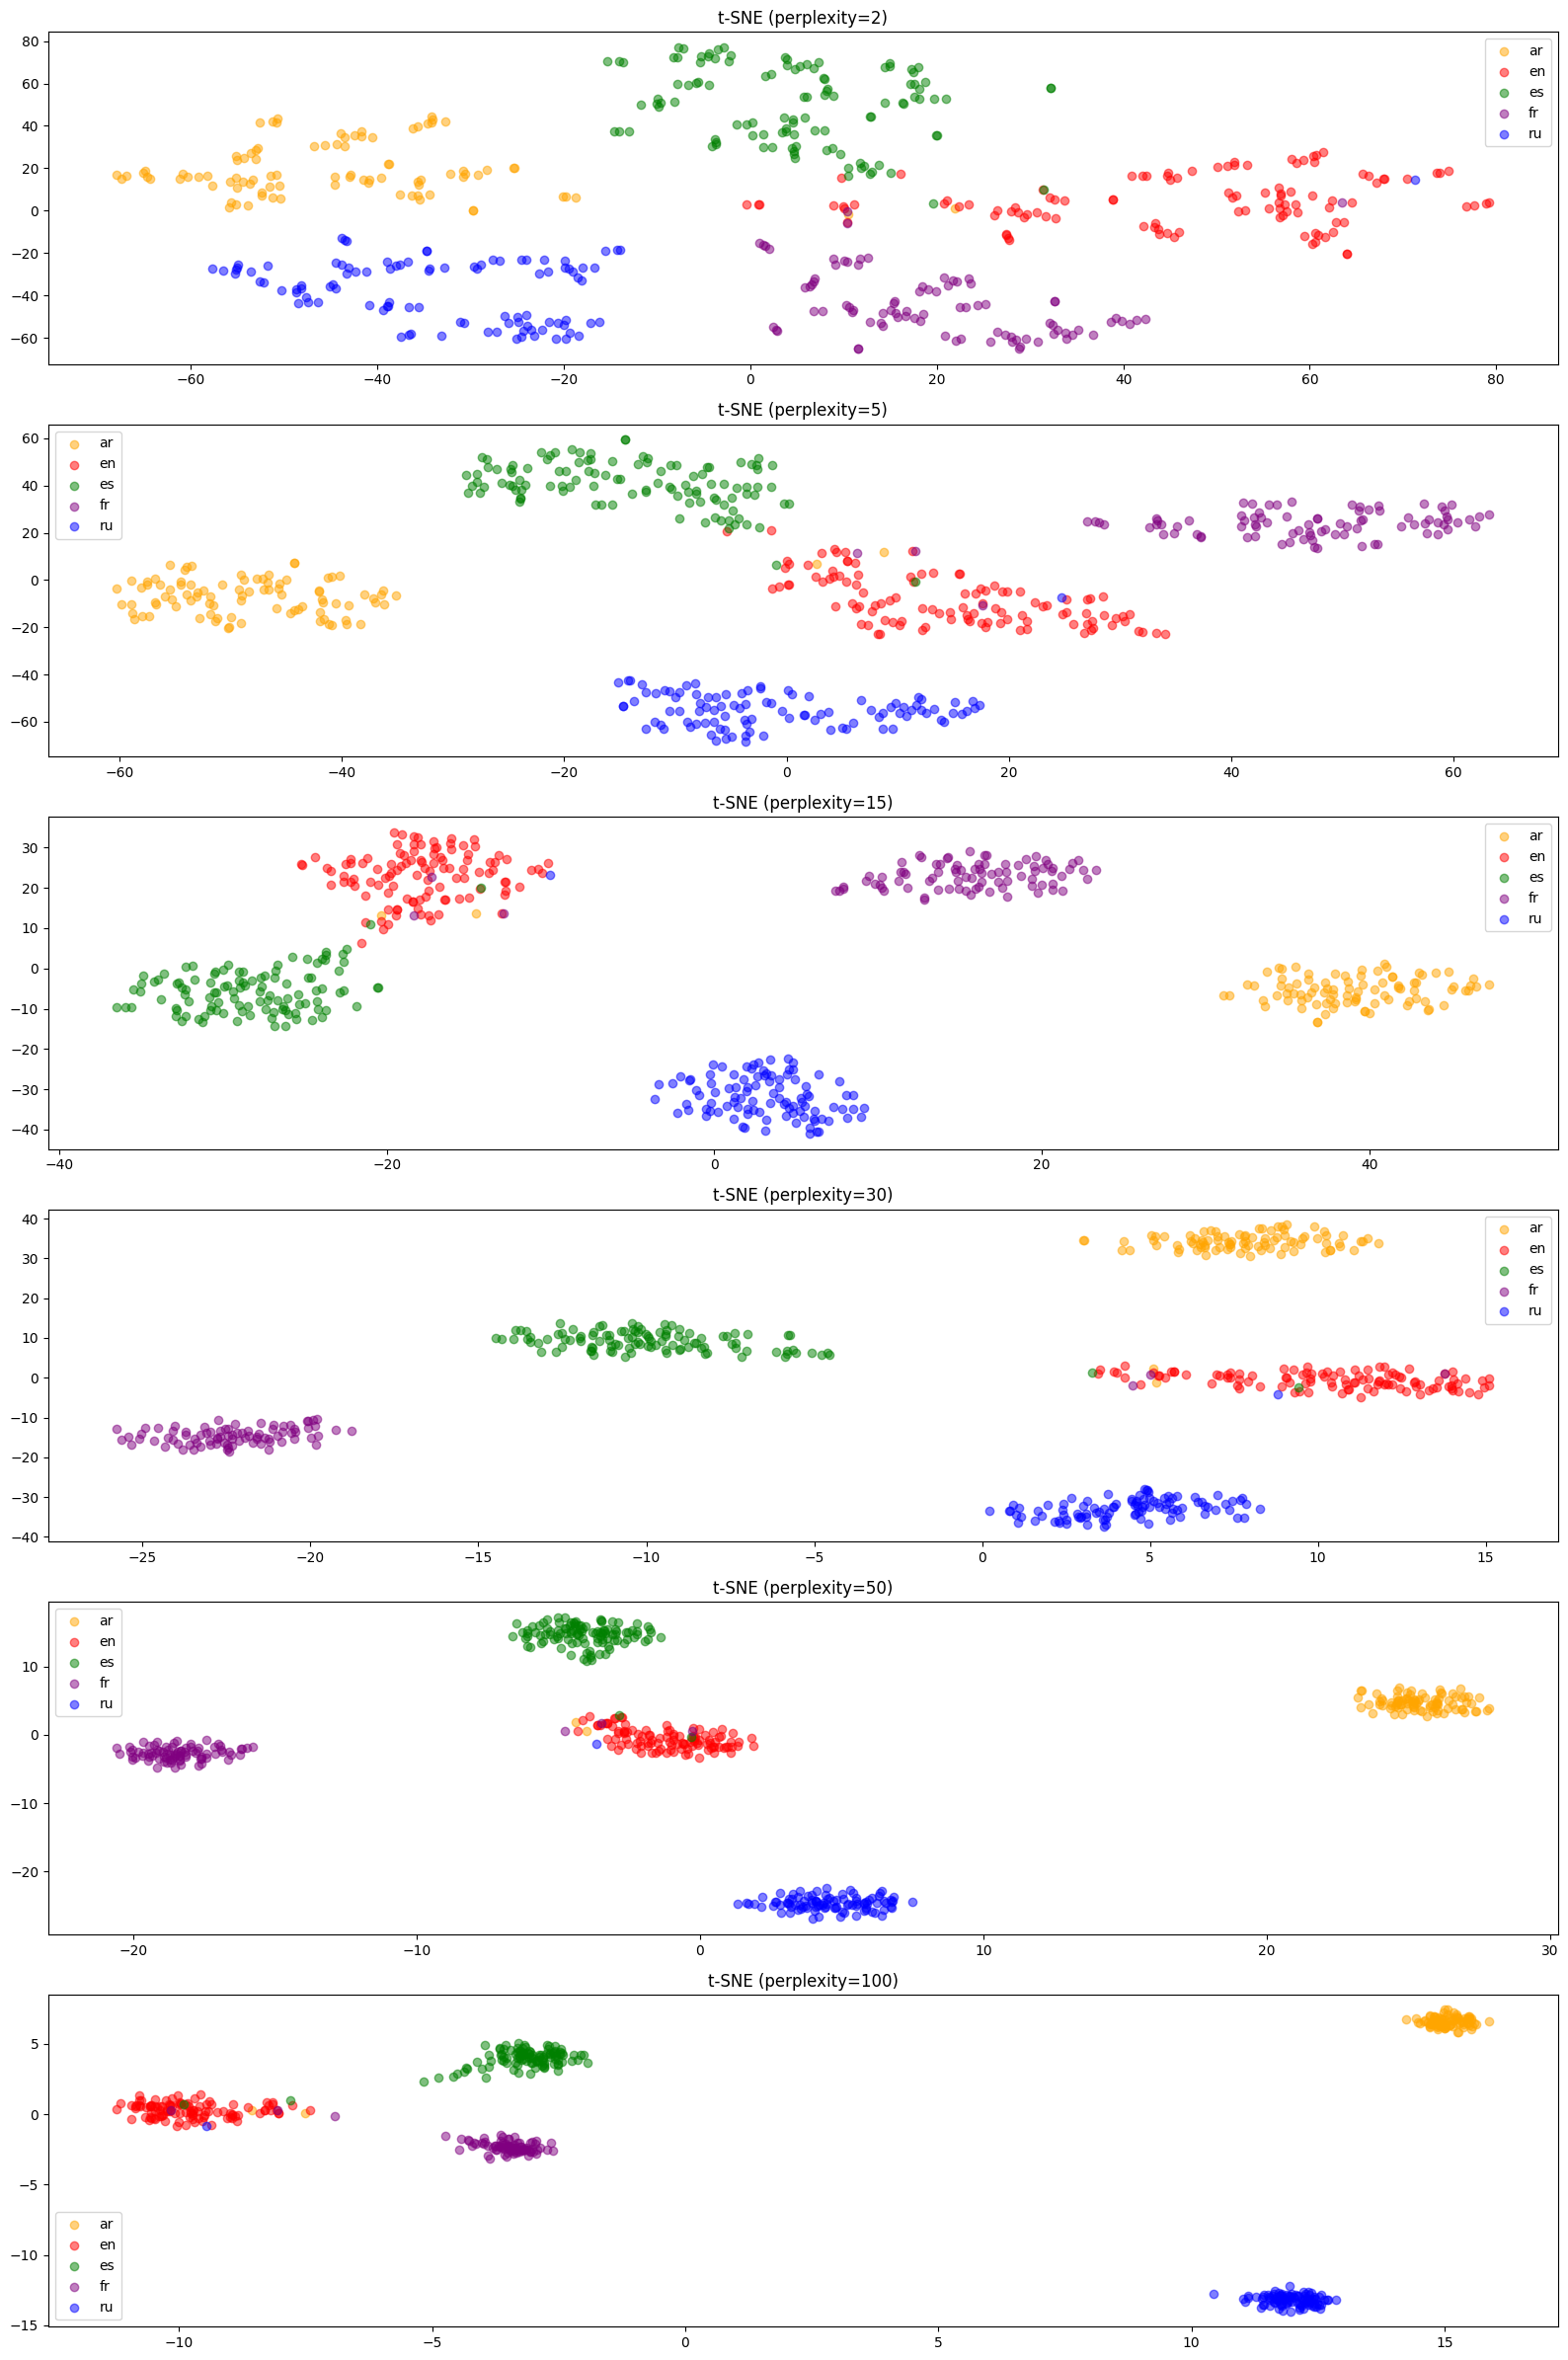

In [18]:
plot_tsne_with_different_perplexities(embeddings, all_labels, [2, 5, 15, 30, 50, 100], n_samples=500)

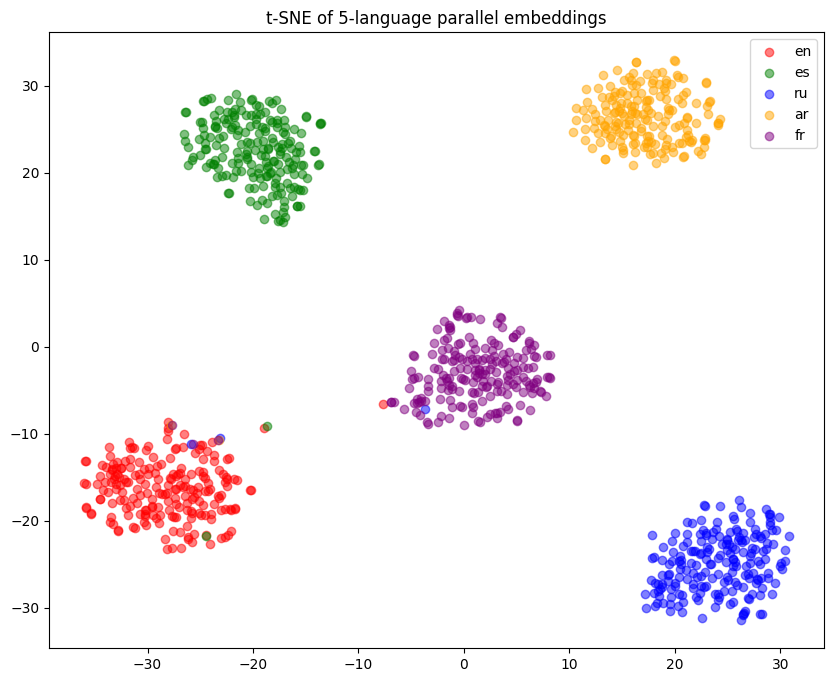

In [19]:
N_TSNE = 1000
if len(all_sentences) > N_TSNE:
    idx = random.sample(range(len(all_sentences)), N_TSNE)
else:
    idx = range(len(all_sentences))

selected_emb = embeddings[idx, :]
selected_labels = [all_labels[i] for i in idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(selected_emb)

colors = {"en": "red", "es": "green", "ru": "blue", "ar": "orange", "fr": "purple"}

plt.figure(figsize=(10, 8))
for lang in colors.keys():
    xy = tsne_coords[[i for i, l in enumerate(selected_labels) if l == lang]]
    plt.scatter(xy[:, 0], xy[:, 1], c=colors[lang], label=lang, alpha=0.5)

plt.legend()
plt.title("t-SNE of 5-language parallel embeddings")
plt.show()

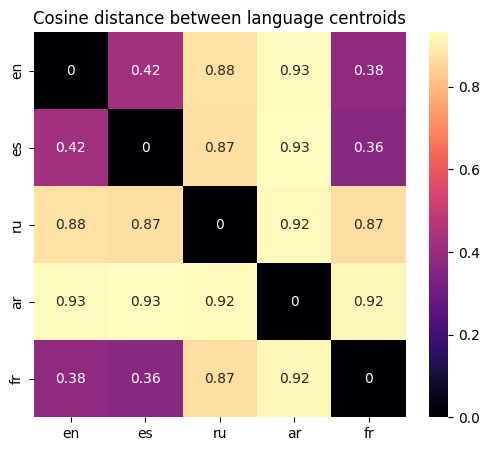

In [20]:
# --------------------------------------------------
# 10. Косинусные расстояния между центроидами языков
# --------------------------------------------------
langs = ["en", "es", "ru", "ar", "fr"]
lang2vecs = {lang: [] for lang in langs}

for emb, label in zip(embeddings, all_labels):
    lang2vecs[label].append(emb)

# Считаем центроиды
lang_centroids = {}
for lang in langs:
    arr = np.vstack(lang2vecs[lang])
    lang_centroids[lang] = arr.mean(axis=0, keepdims=True)

centroids_matrix = np.vstack([lang_centroids[l] for l in langs])
dist_matrix = cosine_distances(centroids_matrix, centroids_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(dist_matrix, xticklabels=langs, yticklabels=langs,
            annot=True, cmap="magma")
plt.title("Cosine distance between language centroids")
plt.show()

---